# Product Impact to Measures: 
## Clustering and Displaying Results
- For this analysis, a set of wordvectors are to be assigned to one of three clusters.  
- there are many clustering algorithms available for this task. We show examples for two methods: k-means clustering and mean shift. Both algorithms take as input a set of unlabeled data points and assigns each to a cluster.  
- Once the data points are assigned a center point and covariance for each cluster can be computed.
- The cluster center point and covariance are then used to draw concentric sigma ellipses along with the original data points.  
- If the data are normally distributed, then the centroid will be near the true KPI-center point (equal if there is infinite sample data) and the ellipses will represent the n-sigma contour of constant probabilty where e.g. 1-sigma will enclose 68%, 2-sigma encloses 95%, .... and these datapoints will be evenly distributed in each contour.
- If the data are not guassian, the centroid and KPI center will differ and the data will not be evenly distributed in the ellipse.

### References:

* Clustering <br />
Clustering is a class of unsupervised ML techniques by which we can associate word2vec data points with three clusters: promoter, passive and detractor. There are many clustering techiques and in this paper we will offer implementations of k-means and mean-shift algorithms. It will be up to Product or Research to determine the clustering technique that performs best in this particular appliction: <br /> 
    + http://scikit-learn.org/stable/modules/clustering.html  <br /> 


* Ellipsoids <br /> 
Note concepts of interia and covariance are related. In the case of a full covariance, the constant probability contours are ellipses. The orientation of the ellipses is determined by the covariance matrix's eigenvectors and the eignvalues determine the (stretch, squish) distortion relative to a unit circle. 

    + https://en.wikipedia.org/wiki/Confidence_region  <br /> 
    + https://en.wikipedia.org/wiki/Singular_value_decomposition

* Multiple Correspondence Analysis <br /> 
These building blocks are intended to support a final design. For more detail on how these concepts are used with Multiple correspondence analysis:
    Multile correspondence analysis visualization:  <br />
    + https://www.youtube.com/watch?v=b4kRAt4mkB8  <br /> 
    + https://www.youtube.com/watch?v=OZW1KrKO5Ac  <br /> 
    + https://www.youtube.com/watch?v=ffZb9wAiElk  <br /> 

In [1]:
import numpy as np
import pandas as pd
from itertools import cycle
import sklearn

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
def draw_ellipse(position, covariance, nsig_max = 3, ax=None, **kwargs):
    """Draw an ellipse with a given center position and sigma covariance rings"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, nsig_max):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# Generate some simulated data
- In this analysis we will be simulating data for a "Product Impact to Measures" analysis. The simulated data is drawn from a Normal Gaussian distirbution. A single color is used b/c the point clouds are being presented without labels.  The algorithms below will be finding the best cluster definitions that organize the data and, in the process, assigning data points to a cluster.
- We expect there to be more promoters than detractors and passives. Version .20 of scikit learn is needed to simulate clusters of varying # of samples

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.0.


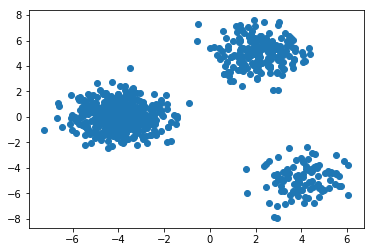

In [4]:
n_samples = tuple([500, 200, 100])
center_promoters = (-4, 0)
center_passives = (2, 5)
center_detractors = (4, -5)

centers = [center_promoters, center_passives, center_detractors]
df_centers = pd.DataFrame(centers,columns = ['x','y'])

X, y = make_blobs(n_samples, n_features=2, cluster_std=1.0,\
                  centers=centers, shuffle=False, random_state=42)


fig = plt.figure(1)
plt.clf()

ax0 = plt.gca()

ax0.scatter(X[:, 0], X[:, 1])
plt.show()

# Algorithm Option 1:
## K-means clustering 
-    In this section we will use the k-means clustering technique to assign the data points to each of three clusters: promoters, detractors, passives. That is, the number of clusters in this problem, is the number of KPI bins.
https://en.wikipedia.org/wiki/K-means_clustering

In [10]:
# Number of clusters for this problem is the number of KPI bins. Since we are interested
#       in promoters, passives and detractors, there are three clusters/
kmeans = KMeans(n_clusters=3)

# Fitting the input data
kmeans = kmeans.fit(X)

# Getting the cluster labels
km_labels = kmeans.predict(X)

# Centroid values are the estimated center points for each of the three clusters
km_centroids = kmeans.cluster_centers_

##  Display the k-means clusters and data
- Plot the k-means determined cluster assignments and covariance for each

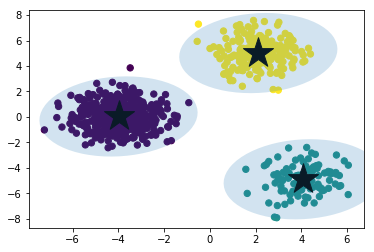

In [11]:
plt.figure(2)
plt.clf()
ax2 = plt.gca()
ax2.scatter(X[:, 0], X[:, 1], c=km_labels, s=40, cmap='viridis')
ax2.scatter(km_centroids[:, 0], km_centroids[:, 1], marker='*', c='#050505', s=1000)

# putting the data into a convenient dataframe allowing visualization via a straightforward loop

df_labeled_data = pd.DataFrame({'x_coord':X[:,0],'y_coord':X[:,1], 'label': km_labels})
df_data_centroids = pd.DataFrame({'center_x':km_centroids[:,0],'center_y':km_centroids[:,1], 'label': list(set(km_labels))})
df_data_centers = pd.DataFrame({'center_x':df_centers['x'],'center_y':df_centers['y'], 'label': list(set(km_labels))})

# The ellipses are being computed wrt the estimated centroid. If the data is Guassian, then the centriod and center
# will be nearly the same.  If the data is not Gaussian we may wish to display the ellipse wrt to the known KPI
# center points

nsig_max = 2
for label in set(km_labels):
    # compute the covariance of each cluster
    my_covar = np.cov(df_labeled_data["x_coord"].tolist(),df_labeled_data["y_coord"].tolist())
    # compute the covariance of each cluster
    my_center = df_data_centroids.loc[label,"center_x":"center_y"].tolist()
    draw_ellipse(my_center, my_covar, nsig_max,  ax2, alpha = 0.2)
plt.show()

# Algorithm Option 2:
## Mean Shift Algorithm

Mean shift is a robust mode-seeking algorithm. It works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

https://en.wikipedia.org/wiki/Mean_shift

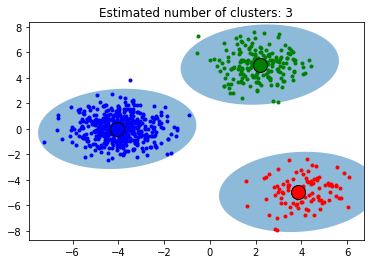

In [12]:
# The kmeans cluster with the most samples is being used to estimate the bandwidth parameter
counts = np.bincount(km_labels)
idxmax = np.argmax(counts)

df_max = df_labeled_data[df_labeled_data["label"] == idxmax]
xp_ = df_max.loc[:, "x_coord":"y_coord"].as_matrix()

bandwidth = estimate_bandwidth(xp_, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, seeds = df_centers.as_matrix(), cluster_all = True)

mean_shift = ms.fit(X)
ms_labels = ms.predict(X)
ms_labels_unique = np.unique(ms_labels)
ms_centroids = ms.cluster_centers_

n_clusters_ = len(ms_labels_unique)


plt.figure(3)
plt.clf()
ax3 = plt.gca()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = ms_labels == k
    cluster_center = ms_centroids[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)

# putting the data into a convenient dataframe allowing visualization via a straightforward loop

df_labeled_data = pd.DataFrame({'x_coord':X[:,0],'y_coord':X[:,1], 'label': ms_labels})
df_data_centroids = pd.DataFrame({'center_x':ms_centroids[:,0],'center_y':ms_centroids[:,1], 'label': ms_labels_unique})
df_data_centers = pd.DataFrame({'center_x':df_centers['x'],'center_y':df_centers['y'], 'label': ms_labels_unique})


# The ellipses are being computed wrt the estimated centroid. If the data is Guassian, then the centriod and center
# will be nearly the same.  If the data is not Gaussian we may wish to display the ellipse wrt to the known KPI
# center points

nsig_max = 2
for label in set(km_labels):
    # compute the covariance of each cluster
    my_covar = np.cov(df_labeled_data["x_coord"].tolist(),df_labeled_data["y_coord"].tolist())
    # compute the covariance of each cluster
    my_center = df_data_centroids.loc[label,"center_x":"center_y"].tolist()
    draw_ellipse(my_center, my_covar, nsig_max,  ax3, alpha = 0.5)
plt.show()


# Algorithm Option 3:
## DB Scan Algorithm

DB scan groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature. 

+ DBSCAN attributes:
    -can find arbitrarily shaped clusters.
    - has a notion of noise, and is robust to outliers. 
    - cannot cluster data sets well with large differences in densities

https://en.wikipedia.org/wiki/DBSCAN <br /> 
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html<br /> 

Number of clusters: 3


/Users/loubellaire/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/loubellaire/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice.


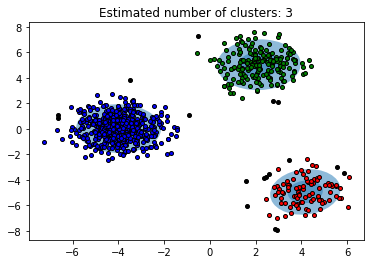

In [7]:
Xprime = StandardScaler().fit_transform(X)
db = DBSCAN(eps=.25, min_samples=5)

dbscan = db.fit(Xprime)
dbscan_labels = db.fit_predict(Xprime)
unique_labels = set(dbscan_labels)

dscan_core = dbscan.core_sample_indices_
core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
core_samples_mask[dscan_core] = True

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print('Number of clusters: %d' % num_clusters)

plt.figure(4)
plt.clf()
ax4 = plt.gca()
nsig_max = 3

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)

    xy = X[class_member_mask & core_samples_mask]
    my_covar = np.cov(xy[:,0],xy[:,1])
    my_center = xy.mean(axis=0)
    
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=8)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=8)
    
    if np.isnan(my_center).any() == False:
        draw_ellipse(my_center, my_covar, nsig_max,  ax4, alpha = 0.5)

plt.title('Estimated number of clusters: %d' % num_clusters)
plt.show()